# FIFA Players Classification

This notebook contains the code to train models for the FIFA Classification problem based on their attributes

## Step 1: Import libraries

Libraries we will be using:
- **tensorflow** and **keras**: APIs for neural network model construction and training
- **numpy**: Numerical python library.
- **pandas**: Will be used to work with dataframes from .csv files.
- **sklearn**: Will be used to modify the labels of the data and do some statistical modifications.
- **matplotlib**: Will be used to plot graphics.
- **time**: To measure training time.
- **datetime**: To get the datetime a new model is created and use that to create its name

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime

## Step 2: Load data

We first define the path to our data

In [2]:
DATA_FOLDER = "../Data"

ATT_FILE = f"{DATA_FOLDER}/FootballPlayerPreparedCleanAttributes.csv"
IMPUTED_ATT_FILE = f"{DATA_FOLDER}/ImputedFootballPlayerPreparedCleanAttributes.csv"

ONE_HOT_LABEL_FILE = f"{DATA_FOLDER}/FootballPlayerOneHotEncodedClasses.csv"
IMPUTED_ONE_HOT_LABEL_FILE = f"{DATA_FOLDER}/ImputedFootballPlayerOneHotEncodedClasses.csv"

Specify training options:
- **IMPUTED_DATA**: We will use file with data imputed
- **TRAIN_RATE**: The amount of instances to use during training, it will also determine the dev and test instances number indirectly

In [3]:
IMPUTED_DATA = True    # Use imputed dataset
TRAIN_RATE = 0.8        # The division of the data for training, validation and test

Because our data has more than 10000, we will be using 80-10-10 split in our dataset:
- **80%** for training
- **10%** for validation/dev test
- **10%** for final test

In [4]:
if IMPUTED_DATA:
    attributes = pd.read_csv(IMPUTED_ATT_FILE)
    labels = pd.read_csv(IMPUTED_ONE_HOT_LABEL_FILE)
else:
    attributes = pd.read_csv(ATT_FILE)
    labels = pd.read_csv(ONE_HOT_LABEL_FILE)

n_total_instances = attributes.shape[0]
n_train_instances = int(n_total_instances * TRAIN_RATE)
n_dev_instances = int((n_total_instances - n_train_instances)/2)

instances_train = attributes.values[:n_train_instances]
labels_train = labels.values[:n_train_instances]

instances_dev = attributes.values[n_train_instances: n_train_instances + n_dev_instances]
labels_dev = labels.values[n_train_instances: n_train_instances + n_dev_instances]

print("instances_train:", instances_train.shape)
print("labels_train:", labels_train.shape)
print("instances_dev:", instances_dev.shape)
print("labels_dev:",labels_dev.shape)

instances_train: (12945, 16)
labels_train: (12945, 4)
instances_dev: (1618, 16)
labels_dev: (1618, 4)


## Step 3: Initialize variables
- **INPUT_SIZE**: The size of the training instances
- **OUTPUT_SIZE**: The number of possible classes
- **NUM_TRAINING_EXAMPLES**: The number of possible classes
- **NUM_DEV_EXAMPLES**: The number of validation/dev test instances

In [5]:
INPUT_SIZE = instances_train.shape[1]
print(INPUT_SIZE)
OUTPUT_SIZE = labels_train.shape[1]
print(OUTPUT_SIZE)
NUM_TRAINING_EXAMPLES = int(round(instances_train.shape[0]/1))
NUM_DEV_EXAMPLES = int(round(instances_dev.shape[0]/1))

16
4


## Step 4: Set hyperparameters

- **LEARNING_RATE** $\alpha$: The step size in the learning process
- **BATCH_SIZE**: The size of each batch
- **N_HIDDEN**: Number of neurons in the hidden.

The learning process stops when it reaches 20,000 learning iterations. An iteration comprises presenting the network *batch_size* learning examples and then adjusting the weights (parameters).

In [6]:
N_EPOCHS = 1000
LEARNING_RATE = 0.1
BATCH_SIZE = 512
ACTIVATION = "relu"
N_HIDDEN = [512]
REGULARIZER = keras.regularizers.l1(0.0001)
INITIALIZER = keras.initializers.he_normal(seed=None)
LOSS = tf.keras.losses.categorical_crossentropy
OPTIMIZER = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE)
METRICS = ["categorical_accuracy"]

## Step 5: Build the model

In [7]:
def architecture1():
    model = keras.Sequential(name="Model")
    model.add(keras.layers.InputLayer(input_shape=(INPUT_SIZE,), batch_size=None))
    for neurons in N_HIDDEN:
        model.add(keras.layers.Dense(neurons, activation=ACTIVATION))
    model.add(keras.layers.Dense(OUTPUT_SIZE, activation="softmax"))
    
    model_name = "D512"
    return model, model_name


def architecture2():
    model = keras.Sequential(name="Model")
    model.add(keras.layers.InputLayer(input_shape=(INPUT_SIZE,),
                                      batch_size=None))
    for neurons in N_HIDDEN:
        model.add(keras.layers.Dense(neurons,
                                     activation=ACTIVATION,
                                     kernel_regularizer=REGULARIZER
                                    ))
        
    model.add(keras.layers.Dense(OUTPUT_SIZE, 
                                 activation="softmax"))
    
    model_name = "D128_D64_D32"
    return model, model_name

def architecture3():
    model = keras.Sequential(name="Model")
    model.add(keras.layers.InputLayer(input_shape=(INPUT_SIZE,),
                                      batch_size=None))
    
    for neurons in N_HIDDEN:
        model.add(keras.layers.Dense(neurons))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation(ACTIVATION))
        
    model.add(keras.layers.Dense(OUTPUT_SIZE,
                                 activation="softmax"
                                ))
    model_name = "D128_BN_D64_BN_D32_BN"
    return model, model_name

def architecture4():
    model = keras.Sequential(name="Model")
    model.add(keras.layers.InputLayer(input_shape=(INPUT_SIZE,),
                                      batch_size=None))
    
    for neurons in N_HIDDEN:
        model.add(keras.layers.Dense(neurons,
                                     kernel_regularizer=REGULARIZER,
                                     kernel_initializer=keras.initializers.HeNormal(seed=None),
                                     use_bias=False
                                     ))
    
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation(ACTIVATION))
        
    model.add(keras.layers.Dense(OUTPUT_SIZE,
                                 activation="softmax"
                                ))
    model_name = "D2048_BN_D1024_BN_D512_BN_D256_BN_D128_BN_D64_BN_D32_BN"
    return model, model_name


def architecture5():
    model = keras.Sequential(name="Model")
    model.add(keras.layers.InputLayer(input_shape=(INPUT_SIZE,),
                                      batch_size=None))
    
    for neurons in N_HIDDEN:
        model.add(keras.layers.Dense(neurons,
                                     kernel_regularizer=REGULARIZER,
                                     kernel_initializer=keras.initializers.HeNormal(seed=None),
                                     use_bias=False
                                     ))
    
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation(ACTIVATION))
        
    model.add(keras.layers.Dense(OUTPUT_SIZE,
                                 activation="softmax"
                                ))
    
    model_name = "D512_BN_D128_BN_D32_BN_D128_BN_D512_BN"
    return model, model_name

def architecture5dr():
    model = keras.Sequential(name="Model")
    model.add(keras.layers.InputLayer(input_shape=(INPUT_SIZE,),
                                      batch_size=None))
    
    for neurons in N_HIDDEN:
        model.add(keras.layers.Dense(neurons,
                                     kernel_regularizer=REGULARIZER,
                                     kernel_initializer=keras.initializers.HeNormal(seed=None),
                                     use_bias=False
                                     ))
        model.add(keras.layers.Dropout(rate=0.1))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation(ACTIVATION))
        
    model.add(keras.layers.Dense(OUTPUT_SIZE,
                                 activation="softmax"
                                ))
    
    model_name = "D512_DR_BN_D128_DR_BN_D32_DR_BN_D128_DR_BN_D512_DR_BN"
    return model, model_name


def compile_model(model):
    my_model.compile(loss=LOSS,
                     optimizer=OPTIMIZER,
                     metrics=METRICS)

In [8]:
my_model, model_name = architecture1()

In [9]:
compile_model(my_model)

## Step 6: Train the model

In [10]:
start_time = time.perf_counter()
history = my_model.fit(instances_train,
                       labels_train,
                       batch_size=BATCH_SIZE,
                       epochs=N_EPOCHS,
                       verbose=1,
                       validation_data=(instances_dev, labels_dev))
end_time = time.perf_counter()

Epoch 1/1000
26/26 [==============================] - 1s 10ms/step - loss: 1.2275 - categorical_accuracy: 0.5124 - val_loss: 1.1137 - val_categorical_accuracy: 0.5680
Epoch 2/1000
26/26 [==============================] - 0s 5ms/step - loss: 1.0498 - categorical_accuracy: 0.5770 - val_loss: 1.0085 - val_categorical_accuracy: 0.5939
Epoch 3/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.9660 - categorical_accuracy: 0.5982 - val_loss: 0.9470 - val_categorical_accuracy: 0.6026
Epoch 4/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.9105 - categorical_accuracy: 0.6142 - val_loss: 0.9001 - val_categorical_accuracy: 0.6224
Epoch 5/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.8673 - categorical_accuracy: 0.6298 - val_loss: 0.8602 - val_categorical_accuracy: 0.6440
Epoch 6/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.8306 - categorical_accuracy: 0.6447 - val_loss: 0.8251 - val_categorical_accuracy: 0.6607
Epo

26/26 [==============================] - 0s 4ms/step - loss: 0.5615 - categorical_accuracy: 0.7494 - val_loss: 0.5478 - val_categorical_accuracy: 0.7577
Epoch 51/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.5604 - categorical_accuracy: 0.7493 - val_loss: 0.5485 - val_categorical_accuracy: 0.7633
Epoch 52/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.5590 - categorical_accuracy: 0.7511 - val_loss: 0.5476 - val_categorical_accuracy: 0.7590
Epoch 53/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.5586 - categorical_accuracy: 0.7520 - val_loss: 0.5489 - val_categorical_accuracy: 0.7583
Epoch 54/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.5582 - categorical_accuracy: 0.7498 - val_loss: 0.5480 - val_categorical_accuracy: 0.7670
Epoch 55/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.5570 - categorical_accuracy: 0.7508 - val_loss: 0.5444 - val_categorical_accuracy: 0.7633
Epoch 56/100

26/26 [==============================] - 0s 7ms/step - loss: 0.5286 - categorical_accuracy: 0.7633 - val_loss: 0.5210 - val_categorical_accuracy: 0.7651
Epoch 100/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.5285 - categorical_accuracy: 0.7628 - val_loss: 0.5174 - val_categorical_accuracy: 0.7744
Epoch 101/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.5281 - categorical_accuracy: 0.7635 - val_loss: 0.5185 - val_categorical_accuracy: 0.7664
Epoch 102/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.5273 - categorical_accuracy: 0.7635 - val_loss: 0.5207 - val_categorical_accuracy: 0.7726
Epoch 103/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.5271 - categorical_accuracy: 0.7643 - val_loss: 0.5190 - val_categorical_accuracy: 0.7633
Epoch 104/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.5267 - categorical_accuracy: 0.7646 - val_loss: 0.5175 - val_categorical_accuracy: 0.7750
Epoch 1

Epoch 148/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.5072 - categorical_accuracy: 0.7743 - val_loss: 0.5013 - val_categorical_accuracy: 0.7750
Epoch 149/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.5069 - categorical_accuracy: 0.7764 - val_loss: 0.4994 - val_categorical_accuracy: 0.7824
Epoch 150/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.5066 - categorical_accuracy: 0.7751 - val_loss: 0.4993 - val_categorical_accuracy: 0.7800
Epoch 151/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.5059 - categorical_accuracy: 0.7744 - val_loss: 0.4986 - val_categorical_accuracy: 0.7800
Epoch 152/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.5057 - categorical_accuracy: 0.7743 - val_loss: 0.4988 - val_categorical_accuracy: 0.7837
Epoch 153/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.5052 - categorical_accuracy: 0.7757 - val_loss: 0.5037 - val_categorical_accuracy:

Epoch 197/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4900 - categorical_accuracy: 0.7839 - val_loss: 0.4865 - val_categorical_accuracy: 0.7849
Epoch 198/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4896 - categorical_accuracy: 0.7839 - val_loss: 0.4859 - val_categorical_accuracy: 0.7849
Epoch 199/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4891 - categorical_accuracy: 0.7832 - val_loss: 0.4842 - val_categorical_accuracy: 0.7892
Epoch 200/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4888 - categorical_accuracy: 0.7851 - val_loss: 0.4864 - val_categorical_accuracy: 0.7837
Epoch 201/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4879 - categorical_accuracy: 0.7838 - val_loss: 0.4850 - val_categorical_accuracy: 0.7862
Epoch 202/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4881 - categorical_accuracy: 0.7852 - val_loss: 0.4839 - val_categorical_accuracy:

Epoch 246/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4738 - categorical_accuracy: 0.7930 - val_loss: 0.4752 - val_categorical_accuracy: 0.7899
Epoch 247/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4733 - categorical_accuracy: 0.7926 - val_loss: 0.4754 - val_categorical_accuracy: 0.7942
Epoch 248/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4727 - categorical_accuracy: 0.7930 - val_loss: 0.4735 - val_categorical_accuracy: 0.7874
Epoch 249/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4723 - categorical_accuracy: 0.7921 - val_loss: 0.4734 - val_categorical_accuracy: 0.7862
Epoch 250/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4721 - categorical_accuracy: 0.7935 - val_loss: 0.4755 - val_categorical_accuracy: 0.7855
Epoch 251/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4724 - categorical_accuracy: 0.7931 - val_loss: 0.4731 - val_categorical_accuracy:

Epoch 295/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4587 - categorical_accuracy: 0.8000 - val_loss: 0.4651 - val_categorical_accuracy: 0.7936
Epoch 296/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4581 - categorical_accuracy: 0.7994 - val_loss: 0.4650 - val_categorical_accuracy: 0.7911
Epoch 297/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4576 - categorical_accuracy: 0.7995 - val_loss: 0.4643 - val_categorical_accuracy: 0.7855
Epoch 298/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4571 - categorical_accuracy: 0.8006 - val_loss: 0.4638 - val_categorical_accuracy: 0.7874
Epoch 299/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4570 - categorical_accuracy: 0.7993 - val_loss: 0.4655 - val_categorical_accuracy: 0.7886
Epoch 300/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4570 - categorical_accuracy: 0.7992 - val_loss: 0.4619 - val_categorical_accuracy:

Epoch 344/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4436 - categorical_accuracy: 0.8085 - val_loss: 0.4533 - val_categorical_accuracy: 0.7998
Epoch 345/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4438 - categorical_accuracy: 0.8066 - val_loss: 0.4545 - val_categorical_accuracy: 0.7936
Epoch 346/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4433 - categorical_accuracy: 0.8053 - val_loss: 0.4554 - val_categorical_accuracy: 0.7967
Epoch 347/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4428 - categorical_accuracy: 0.8066 - val_loss: 0.4569 - val_categorical_accuracy: 0.7905
Epoch 348/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4429 - categorical_accuracy: 0.8082 - val_loss: 0.4536 - val_categorical_accuracy: 0.7991
Epoch 349/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4428 - categorical_accuracy: 0.8063 - val_loss: 0.4525 - val_categorical_accuracy:

Epoch 393/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4306 - categorical_accuracy: 0.8128 - val_loss: 0.4459 - val_categorical_accuracy: 0.8053
Epoch 394/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4311 - categorical_accuracy: 0.8134 - val_loss: 0.4436 - val_categorical_accuracy: 0.7960
Epoch 395/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4301 - categorical_accuracy: 0.8138 - val_loss: 0.4458 - val_categorical_accuracy: 0.7954
Epoch 396/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4307 - categorical_accuracy: 0.8126 - val_loss: 0.4456 - val_categorical_accuracy: 0.8004
Epoch 397/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4302 - categorical_accuracy: 0.8133 - val_loss: 0.4431 - val_categorical_accuracy: 0.8059
Epoch 398/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4295 - categorical_accuracy: 0.8124 - val_loss: 0.4436 - val_categorical_accuracy:

Epoch 442/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4194 - categorical_accuracy: 0.8173 - val_loss: 0.4392 - val_categorical_accuracy: 0.7973
Epoch 443/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4194 - categorical_accuracy: 0.8199 - val_loss: 0.4386 - val_categorical_accuracy: 0.8053
Epoch 444/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4196 - categorical_accuracy: 0.8190 - val_loss: 0.4392 - val_categorical_accuracy: 0.7967
Epoch 445/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4193 - categorical_accuracy: 0.8180 - val_loss: 0.4345 - val_categorical_accuracy: 0.8022
Epoch 446/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4186 - categorical_accuracy: 0.8203 - val_loss: 0.4361 - val_categorical_accuracy: 0.8109
Epoch 447/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4188 - categorical_accuracy: 0.8187 - val_loss: 0.4417 - val_categorical_accuracy:

Epoch 491/1000
26/26 [==============================] - 0s 8ms/step - loss: 0.4097 - categorical_accuracy: 0.8216 - val_loss: 0.4285 - val_categorical_accuracy: 0.8090
Epoch 492/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4089 - categorical_accuracy: 0.8237 - val_loss: 0.4315 - val_categorical_accuracy: 0.8121
Epoch 493/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4091 - categorical_accuracy: 0.8227 - val_loss: 0.4369 - val_categorical_accuracy: 0.8010
Epoch 494/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4096 - categorical_accuracy: 0.8235 - val_loss: 0.4277 - val_categorical_accuracy: 0.8053
Epoch 495/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4090 - categorical_accuracy: 0.8226 - val_loss: 0.4294 - val_categorical_accuracy: 0.8078
Epoch 496/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4090 - categorical_accuracy: 0.8226 - val_loss: 0.4260 - val_categorical_accuracy:

Epoch 540/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4004 - categorical_accuracy: 0.8280 - val_loss: 0.4201 - val_categorical_accuracy: 0.8084
Epoch 541/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4003 - categorical_accuracy: 0.8271 - val_loss: 0.4256 - val_categorical_accuracy: 0.8028
Epoch 542/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4000 - categorical_accuracy: 0.8278 - val_loss: 0.4262 - val_categorical_accuracy: 0.8152
Epoch 543/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.4001 - categorical_accuracy: 0.8263 - val_loss: 0.4230 - val_categorical_accuracy: 0.8127
Epoch 544/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3998 - categorical_accuracy: 0.8297 - val_loss: 0.4243 - val_categorical_accuracy: 0.8140
Epoch 545/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3997 - categorical_accuracy: 0.8292 - val_loss: 0.4187 - val_categorical_accuracy:

Epoch 589/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3917 - categorical_accuracy: 0.8321 - val_loss: 0.4216 - val_categorical_accuracy: 0.8146
Epoch 590/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3917 - categorical_accuracy: 0.8316 - val_loss: 0.4152 - val_categorical_accuracy: 0.8152
Epoch 591/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3920 - categorical_accuracy: 0.8317 - val_loss: 0.4194 - val_categorical_accuracy: 0.8158
Epoch 592/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3907 - categorical_accuracy: 0.8311 - val_loss: 0.4130 - val_categorical_accuracy: 0.8133
Epoch 593/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3905 - categorical_accuracy: 0.8322 - val_loss: 0.4139 - val_categorical_accuracy: 0.8103
Epoch 594/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3907 - categorical_accuracy: 0.8317 - val_loss: 0.4148 - val_categorical_accuracy:

Epoch 638/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3848 - categorical_accuracy: 0.8345 - val_loss: 0.4138 - val_categorical_accuracy: 0.8201
Epoch 639/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3840 - categorical_accuracy: 0.8346 - val_loss: 0.4185 - val_categorical_accuracy: 0.8152
Epoch 640/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3837 - categorical_accuracy: 0.8350 - val_loss: 0.4060 - val_categorical_accuracy: 0.8208
Epoch 641/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3839 - categorical_accuracy: 0.8341 - val_loss: 0.4085 - val_categorical_accuracy: 0.8195
Epoch 642/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3829 - categorical_accuracy: 0.8360 - val_loss: 0.4081 - val_categorical_accuracy: 0.8208
Epoch 643/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3824 - categorical_accuracy: 0.8349 - val_loss: 0.4070 - val_categorical_accuracy:

Epoch 687/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3758 - categorical_accuracy: 0.8379 - val_loss: 0.4009 - val_categorical_accuracy: 0.8133
Epoch 688/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3760 - categorical_accuracy: 0.8396 - val_loss: 0.4023 - val_categorical_accuracy: 0.8171
Epoch 689/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3758 - categorical_accuracy: 0.8387 - val_loss: 0.4003 - val_categorical_accuracy: 0.8226
Epoch 690/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3756 - categorical_accuracy: 0.8399 - val_loss: 0.4020 - val_categorical_accuracy: 0.8232
Epoch 691/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3755 - categorical_accuracy: 0.8381 - val_loss: 0.4086 - val_categorical_accuracy: 0.8115
Epoch 692/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3759 - categorical_accuracy: 0.8377 - val_loss: 0.4002 - val_categorical_accuracy:

Epoch 736/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3694 - categorical_accuracy: 0.8412 - val_loss: 0.3958 - val_categorical_accuracy: 0.8183
Epoch 737/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3694 - categorical_accuracy: 0.8416 - val_loss: 0.4068 - val_categorical_accuracy: 0.8189
Epoch 738/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3697 - categorical_accuracy: 0.8399 - val_loss: 0.4038 - val_categorical_accuracy: 0.8183
Epoch 739/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3694 - categorical_accuracy: 0.8418 - val_loss: 0.3961 - val_categorical_accuracy: 0.8226
Epoch 740/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3687 - categorical_accuracy: 0.8423 - val_loss: 0.3946 - val_categorical_accuracy: 0.8214
Epoch 741/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3690 - categorical_accuracy: 0.8423 - val_loss: 0.3968 - val_categorical_accuracy:

Epoch 785/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3640 - categorical_accuracy: 0.8460 - val_loss: 0.3939 - val_categorical_accuracy: 0.8226
Epoch 786/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3638 - categorical_accuracy: 0.8441 - val_loss: 0.3930 - val_categorical_accuracy: 0.8220
Epoch 787/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3640 - categorical_accuracy: 0.8445 - val_loss: 0.3991 - val_categorical_accuracy: 0.8201
Epoch 788/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3642 - categorical_accuracy: 0.8438 - val_loss: 0.4083 - val_categorical_accuracy: 0.8201
Epoch 789/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3639 - categorical_accuracy: 0.8443 - val_loss: 0.3932 - val_categorical_accuracy: 0.8220
Epoch 790/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3629 - categorical_accuracy: 0.8456 - val_loss: 0.3969 - val_categorical_accuracy:

Epoch 834/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3592 - categorical_accuracy: 0.8475 - val_loss: 0.3934 - val_categorical_accuracy: 0.8282
Epoch 835/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3580 - categorical_accuracy: 0.8463 - val_loss: 0.3868 - val_categorical_accuracy: 0.8232
Epoch 836/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3576 - categorical_accuracy: 0.8476 - val_loss: 0.3898 - val_categorical_accuracy: 0.8195
Epoch 837/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3583 - categorical_accuracy: 0.8478 - val_loss: 0.3947 - val_categorical_accuracy: 0.8325
Epoch 838/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3583 - categorical_accuracy: 0.8487 - val_loss: 0.3919 - val_categorical_accuracy: 0.8208
Epoch 839/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3580 - categorical_accuracy: 0.8480 - val_loss: 0.3874 - val_categorical_accuracy:

Epoch 883/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3541 - categorical_accuracy: 0.8496 - val_loss: 0.3881 - val_categorical_accuracy: 0.8245
Epoch 884/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3535 - categorical_accuracy: 0.8497 - val_loss: 0.3846 - val_categorical_accuracy: 0.8232
Epoch 885/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3533 - categorical_accuracy: 0.8502 - val_loss: 0.3941 - val_categorical_accuracy: 0.8288
Epoch 886/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3534 - categorical_accuracy: 0.8511 - val_loss: 0.3886 - val_categorical_accuracy: 0.8269
Epoch 887/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3541 - categorical_accuracy: 0.8483 - val_loss: 0.3887 - val_categorical_accuracy: 0.8226
Epoch 888/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3533 - categorical_accuracy: 0.8504 - val_loss: 0.3877 - val_categorical_accuracy:

Epoch 932/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3507 - categorical_accuracy: 0.8494 - val_loss: 0.3964 - val_categorical_accuracy: 0.8152
Epoch 933/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3505 - categorical_accuracy: 0.8520 - val_loss: 0.3823 - val_categorical_accuracy: 0.8245
Epoch 934/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3493 - categorical_accuracy: 0.8530 - val_loss: 0.3838 - val_categorical_accuracy: 0.8282
Epoch 935/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3489 - categorical_accuracy: 0.8504 - val_loss: 0.3842 - val_categorical_accuracy: 0.8288
Epoch 936/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3488 - categorical_accuracy: 0.8522 - val_loss: 0.3889 - val_categorical_accuracy: 0.8189
Epoch 937/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3497 - categorical_accuracy: 0.8543 - val_loss: 0.3872 - val_categorical_accuracy:

Epoch 981/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3469 - categorical_accuracy: 0.8537 - val_loss: 0.3771 - val_categorical_accuracy: 0.8313
Epoch 982/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3452 - categorical_accuracy: 0.8519 - val_loss: 0.3772 - val_categorical_accuracy: 0.8319
Epoch 983/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3449 - categorical_accuracy: 0.8551 - val_loss: 0.3805 - val_categorical_accuracy: 0.8276
Epoch 984/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3442 - categorical_accuracy: 0.8548 - val_loss: 0.3831 - val_categorical_accuracy: 0.8282
Epoch 985/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3458 - categorical_accuracy: 0.8543 - val_loss: 0.3781 - val_categorical_accuracy: 0.8307
Epoch 986/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.3445 - categorical_accuracy: 0.8548 - val_loss: 0.3885 - val_categorical_accuracy:

## Step 7: Analyze results

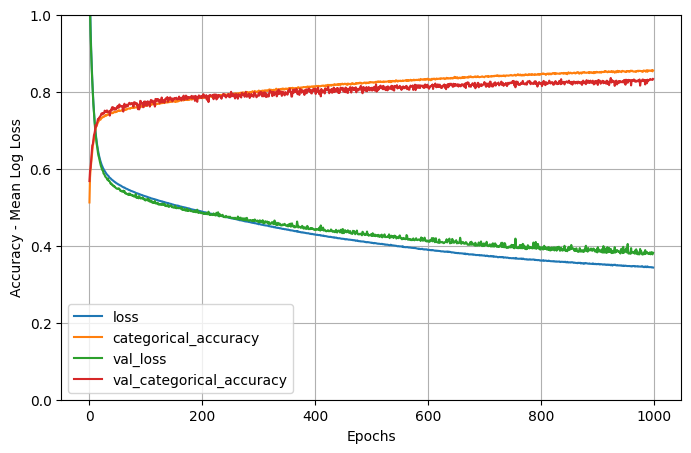

In [11]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [12]:
training_accuracy = round(results.categorical_accuracy.values[-1:][0]*100, 2)
val_accuracy = round(results.val_categorical_accuracy.values[-1:][0]*100, 2)
training_error = round((1 - results.categorical_accuracy.values[-1:][0])*100, 2)
test_error = round((1 - results.val_categorical_accuracy.values[-1:][0])*100, 2)
human_error = 5
bias = round(training_error - human_error, 2)
variance = round(test_error - training_error, 2)
training_time = round(end_time - start_time)
print("Training accuracy: ", training_accuracy, "%")
print("Validationa accuracy", val_accuracy, "%")
print("Error (training):", training_error, "%")
print("Error (test):", test_error, "%")
print("Bias:", bias)
print("Variance:", variance)
print("Time: ", training_time, "seconds")

Training accuracy:  85.52 %
Validationa accuracy 83.31 %
Error (training): 14.48 %
Error (test): 16.69 %
Bias: 9.48
Variance: 2.21
Time:  180 seconds


In [13]:
def draw_confusion_matrix(cm, categories, normalize=True):
    # Draw confusion matrix
    fig = plt.figure(figsize=[3*pow(len(categories), 0.5), 2*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    if normalize:
        cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=categories, yticklabels=categories, ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(12-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)


51/51 [==============================] - 0s 2ms/step


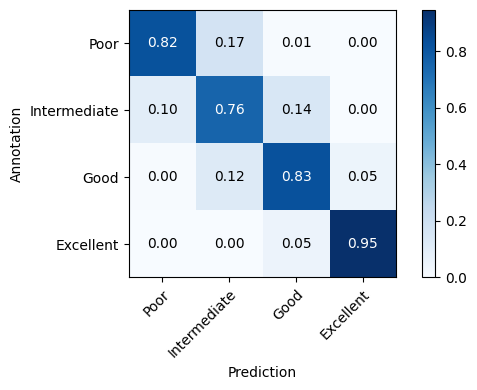

In [14]:
labels_pred = my_model.predict(instances_dev)
cm = confusion_matrix(np.argmax(labels_dev, axis=1), np.argmax(labels_pred, axis=1))
draw_confusion_matrix(cm, ["Poor", "Intermediate", "Good", "Excellent"])

## Step 8: Save results

In [15]:
RESULTS_FOLDER = "../Results"
RESULTS_FILE = f"{RESULTS_FOLDER}/models_performance.csv"

In [16]:
results_df = pd.read_csv(RESULTS_FILE, index_col = 0)

In [17]:
COLUMNS = [
    'model_name',
    'epochs',
    'learning_rate',
    'batch_size',
    'activation',
    'loss',
    'optimizer',
    'regularization',
    'initializer',
    'train_accuracy',
    'validation_accuracy',
    'bias',
    'variance',
    'training_time'
]

new_result = [[
    model_name,
    N_EPOCHS,
    LEARNING_RATE,
    BATCH_SIZE,
    ACTIVATION,
    "categorical_crossentropy",
    "SGD",
    ¨"",
    "",
    training_accuracy,
    val_accuracy,
    bias,
    variance,
    training_time]]

new_result_df = pd.DataFrame(new_result, columns=COLUMNS)
concatenation = pd.concat([results_df, new_result_df], ignore_index=True)
concatenation.to_csv(RESULTS_FILE)


SyntaxError: invalid character '¨' (U+00A8) (3677940246.py, line 26)

In [ ]:
# last_five = results_df.tail(5)
last_five = concatenation.tail(5)
print(last_five)
print("\n---Metrics---")
print(last_five[["train_accuracy", "validation_accuracy", "bias", "variance", "training_time"]].describe())

In [ ]:
MODELS_FOLDER = "../Models"
save_name = f"{MODELS_FOLDER}/{model_name}-7.h5"
my_model.save(save_name)